c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Map:  52%|█████▏    | 7092/13608 [02:09<01:45, 61.88 examples/s]c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Map: 100%|██████████| 13608/13608 [04:01<00:00, 56.37 examples/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` envi

{'eval_loss': 0.23119999468326569, 'eval_accuracy': 0.9161522633744856, 'eval_runtime': 220.0689, 'eval_samples_per_second': 61.835, 'eval_steps_per_second': 3.867, 'epoch': 1.0}
{'loss': 0.3745, 'grad_norm': 1.4095128774642944, 'learning_rate': 3.8260869565217395e-05, 'epoch': 1.1750881316098707}
{'eval_loss': 0.11632706969976425, 'eval_accuracy': 0.9584068195179306, 'eval_runtime': 109.6441, 'eval_samples_per_second': 124.111, 'eval_steps_per_second': 7.761, 'epoch': 2.0}
{'loss': 0.1832, 'grad_norm': 0.44277599453926086, 'learning_rate': 2.6509988249118684e-05, 'epoch': 2.3501762632197414}
{'eval_loss': 0.047480508685112, 'eval_accuracy': 0.9803057025279247, 'eval_runtime': 108.5228, 'eval_samples_per_second': 125.393, 'eval_steps_per_second': 7.842, 'epoch': 3.0}
{'loss': 0.0796, 'grad_norm': 0.044686950743198395, 'learning_rate': 1.4759106933019978e-05, 'epoch': 3.525264394829612}
{'eval_loss': 0.03196456655859947, 'eval_accuracy': 0.9872868900646679, 'eval_runtime': 134.2937, 'ev

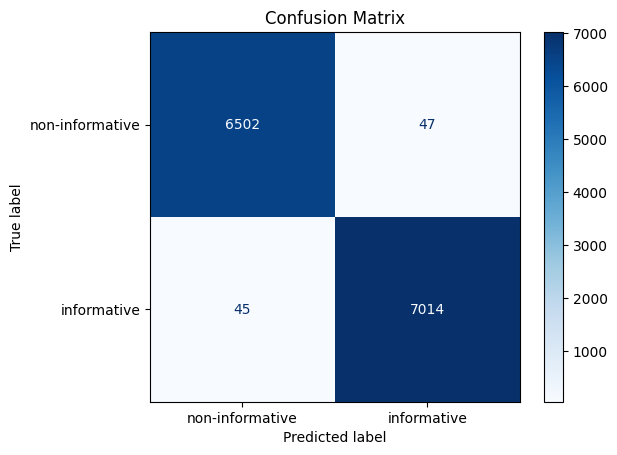

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import Dataset
from PIL import Image
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess the dataset
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
train_data = pd.read_csv(train_file_path, sep='\t')

# Define the image processor
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Preprocessing function for dataset
def preprocess_data(example):
    try:
        # Load the image
        image = Image.open(example["image"])
        
        # Ensure all images are converted to RGB mode
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Process the image
        example["pixel_values"] = image_processor(image, return_tensors="pt")["pixel_values"][0]
    except Exception as e:
        print(f"Error loading image {example['image']}: {e}")
        # Replace invalid images with a dummy tensor
        example["pixel_values"] = torch.zeros((3, 224, 224))  # Dummy tensor for faulty images
    
    # Convert labels to numerical
    example["label"] = 1 if example["label_image"] == "informative" else 0
    return example

# Create a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(train_data)
hf_dataset = hf_dataset.map(preprocess_data)

# Move the dataset to the GPU for faster processing
hf_dataset.set_format(type="torch", columns=["pixel_values", "label"])

# Define the model
modelimage = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", 
    num_labels=2, 
    id2label={0: "non-informative", 1: "informative"}, 
    label2id={"non-informative": 0, "informative": 1}
).to(device)  # Move model to GPU

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./modelimage",  # Output directory
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save the model after each epoch
    logging_dir="./logs",  # Logging directory
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=1000,  # Log every 1000 steps instead of 10
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed-precision training (if available)
    disable_tqdm=True,  # Disable the tqdm progress bar here
)

# Define compute_metrics function
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Create Trainer
trainer = Trainer(
    model=modelimage,
    args=training_args,
    train_dataset=hf_dataset,
    eval_dataset=hf_dataset,  # Using the same dataset for evaluation
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
predictions = trainer.predict(hf_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Accuracy
accuracy = accuracy_score(labels, preds)
print(f"Training Accuracy: {accuracy:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(labels, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["non-informative", "informative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [2]:
# Specify the directory to save the model
save_directory = "D:/BTP_2/CrisisMMD_v2.0/model_image"

# Save the model
modelimage.save_pretrained(save_directory)

# Save the image processor
image_processor.save_pretrained(save_directory)

print(f"Model and image processor saved to {save_directory}")

Model and image processor saved to D:/BTP_2/CrisisMMD_v2.0/model_image
